# Global Macro Long Short Strategy

In [1]:
import yfinance as yf
import pandas as pd
from cvxopt import matrix, solvers
import numpy as np
import datetime as dt
from copy import deepcopy
import matplotlib.pyplot as plt

# 1. Data Preprocessing

In [2]:
etf_tickers = ["FXE", "EWJ", "GLD", "QQQ", "SPY", "SHV", "DBA", "USO", "XBI", "ILF", "EPP", "FEZ"]
start_date = dt.datetime(2017, 3, 1)
end_date = dt.datetime(2024, 3, 1)

In [3]:
data = pd.DataFrame()

for ticker in etf_tickers:
    etf_data = yf.Ticker(ticker).history(start=start_date, end=end_date)
    close_data = etf_data[['Close']].rename(columns={'Close': ticker})

    if data.empty:
        data = close_data
    else:
        data = data.join(close_data, how='outer')

In [4]:
# remove the tz from the index.
data.reset_index(inplace = True)
data['Date'] = pd.to_datetime(data['Date']).apply(lambda x: x.replace(tzinfo = None))
data.set_index('Date', inplace = True)

In [5]:
data.head()

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,XBI,ILF,EPP,FEZ
Date,,,,,,,,,,,,
2017-03-01,99.544136,45.891003,119.059998,124.813805,212.059708,96.386940,18.975739,91.199997,70.938263,21.992867,32.664864,28.534084
2017-03-02,99.164558,45.457153,117.580002,124.187065,210.724243,96.378250,18.836687,89.360001,70.074745,21.312460,32.233982,28.402739
2017-03-03,100.235130,45.483704,117.510002,124.414940,210.856903,96.395683,18.836687,90.320000,70.819168,21.848539,32.278564,28.846035
2017-03-06,99.884773,45.377464,116.720001,124.139565,210.228989,96.378250,18.799610,90.239998,70.203781,21.669847,32.196850,28.698263
2017-03-07,99.758247,45.271202,115.779999,123.930634,209.601044,96.378250,18.623478,90.160004,69.072258,21.614862,32.278564,28.591547


In [6]:
ret_daily = data.pct_change()
ret_daily.tail()

,FXE,EWJ,GLD,QQQ,SPY,SHV,DBA,USO,XBI,ILF,EPP,FEZ
Date,,,,,,,,,,,,
2024-02-23,0.000000,0.001597,0.005652,-0.002945,0.000690,0.000181,0.003169,-0.022826,0.006373,-0.010541,-0.000235,0.000595
2024-02-26,0.002800,-0.000145,-0.002227,-0.000527,-0.003663,0.000000,0.009928,0.012097,0.027335,0.002131,-0.004002,0.001189
2024-02-27,-0.000399,0.002609,-0.001063,0.002405,0.001858,0.000181,0.002681,0.014562,0.057017,0.017718,0.004254,0.004750
2024-02-28,-0.000499,-0.007372,0.001808,-0.005325,-0.001322,0.000091,-0.012032,-0.003114,-0.013218,-0.018454,-0.012003,-0.002167
2024-02-29,-0.003194,0.006553,0.005150,0.008569,0.003595,0.000543,0.000451,-0.003532,-0.030631,-0.003547,0.005002,0.000987


# 2. Investment Strategy

In [7]:
# Set the lookback periods
lookback_periods = {'LT': 120, 'MT': 90, 'MST': 60, 'ST': 30}

# Set the target betas
target_betas = [0, 1]

warmup = 120
rebalance_periods = 5

market_ticker = 'SPY'
SPY_ret = ret_daily[market_ticker]

In [8]:
def backtesting(market_return, portfolio_returns, warmup, lookback, target_beta, rebalance_freq):
    weights = pd.DataFrame(index=market_return.index, columns=portfolio_returns.columns)
    weights.iloc[0] = 0
    
    for i in range(warmup, len(market_return)):
        if i % rebalance_freq == 0:
            current_portfolio_return = portfolio_returns.iloc[i - lookback:i]
            current_market_return = market_return.iloc[i - lookback:i]
            cov_matrix_annualized = current_portfolio_return.cov() * 252
            expected_returns_annualized = current_portfolio_return.mean() * 252

            # Estimate the betas
            n = len(current_portfolio_return.columns)
            betas = {}
            market_variance = np.var(current_market_return)
            for asset in current_portfolio_return.columns:
                cov_i = current_portfolio_return[asset].cov(current_market_return)
                beta_pi = cov_i / market_variance
                betas[asset] = beta_pi
            betas = pd.Series(betas).astype(float)
            target_beta = target_beta

            # print('cov_matrix:', cov_matrix_annualized)
            # print('expected_returns:', expected_returns_annualized)
            # print('betas:', betas)
            # print('target_beta:', target_beta)

            reg_factor = 1e-6
            P = matrix(cov_matrix_annualized.values + reg_factor * np.eye(n))
            q = matrix(-expected_returns_annualized.values)
            G = matrix(np.vstack((-np.eye(n), np.eye(n))))
            h = matrix(np.hstack((0.5 * np.ones(n), 0.5 * np.ones(n))))
            A = matrix(np.vstack((np.ones(n), betas.values)), tc='d')
            b = matrix([1, target_beta], (2, 1), tc='d')

            # print('P', P)
            # print('q', q)
            # print('G', G)
            # print('h', h)
            # print('A', A)
            # print('b', b)

            sol = solvers.qp(P, q, G, h, A, b)

            optimal_weights = pd.Series(sol['x'], index=portfolio_returns.columns)
            # print('optimal_weights:', optimal_weights)
            # print(sum(optimal_weights))
            weights.iloc[i] = optimal_weights
        else:
            weights.iloc[i] = weights.iloc[i - 1]
    return weights

In [9]:
# weight_df = backtesting(SPY_ret, ret_daily, warmup, lookback_periods['LT'], target_betas[1], rebalance_periods)

In [10]:
weights_combined_df = pd.DataFrame()

for lookback in lookback_periods:
    for target_beta in target_betas:
        # Perform backtesting to get the weight_df for the current configuration
        weight_df = backtesting(SPY_ret, ret_daily, warmup, lookback_periods[lookback], target_beta, rebalance_periods)
        
        # Construct the column name based on the lookback period and target beta
        column_name = f"BETA_TARGET_{target_beta}_LOOKBACK_{lookback_periods[lookback]}"
        
        # If weights_combined_df is empty, initialize it with the index from weight_df and empty lists
        if weights_combined_df.empty:
            weights_combined_df = pd.DataFrame(index=weight_df.index)
            weights_combined_df[column_name] = None
            for idx in weights_combined_df.index:
                weights_combined_df.at[idx, column_name] = deepcopy(weight_df.loc[idx].tolist())
        else:
            # If the column does not exist, add it with empty lists
            if column_name not in weights_combined_df.columns:
                weights_combined_df[column_name] = None
                for idx in weights_combined_df.index:
                    weights_combined_df.at[idx, column_name] = []
            
            # Now fill the column with the weights from weight_df
            for idx in weight_df.index:
                if idx in weights_combined_df.index:
                    # Assuming weight_df contains the weights as a list in each row; adjust if necessary
                    weights_combined_df.at[idx, column_name] = deepcopy(weight_df.loc[idx].tolist())
                else:
                    # Handle the case where new dates are present in weight_df but not in weights_combined_df
                    weights_combined_df.at[idx, column_name] = deepcopy(weight_df.loc[idx].tolist())

     pcost       dcost       gap    pres   dres
 0: -1.1418e-01 -1.5242e+01  2e+01  6e-16  5e-16
 1: -1.7865e-01 -1.4901e+00  1e+00  2e-16  8e-16
 2: -5.0299e-01 -6.8393e-01  2e-01  2e-16  2e-16
 3: -5.6885e-01 -6.0398e-01  4e-02  3e-16  2e-16
 4: -5.8120e-01 -5.8566e-01  4e-03  2e-16  2e-16
 5: -5.8243e-01 -5.8267e-01  2e-04  2e-16  2e-16
 6: -5.8252e-01 -5.8254e-01  2e-05  2e-16  1e-16
 7: -5.8253e-01 -5.8253e-01  6e-07  3e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5048e-01 -1.5270e+01  2e+01  7e-16  4e-16
 1: -2.1935e-01 -1.6026e+00  1e+00  2e-16  1e-15
 2: -5.0724e-01 -7.0505e-01  2e-01  2e-16  2e-16
 3: -5.9429e-01 -6.2969e-01  4e-02  3e-16  9e-17
 4: -6.0679e-01 -6.1238e-01  6e-03  3e-16  2e-16
 5: -6.0964e-01 -6.0987e-01  2e-04  4e-16  1e-16
 6: -6.0976e-01 -6.0977e-01  5e-06  3e-16  2e-16
 7: -6.0977e-01 -6.0977e-01  6e-08  3e-16  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5955e-01 -1.5524e

In [11]:
portfolio_ret = pd.DataFrame(index=weights_combined_df.index, columns=weights_combined_df.columns)
for col in weights_combined_df.columns:
    temp_weight_df = weights_combined_df[col].apply(pd.Series).fillna(0)
    temp_weight_df.columns = ret_daily.columns
    temp_port_return = temp_weight_df * ret_daily
    temp_port_return = temp_port_return.sum(axis=1)
    portfolio_ret[col] = temp_port_return

In [12]:
portfolio_ret['SPY'] = SPY_ret
portfolio_ret.fillna(0, inplace=True)

# 3. Performance and Risk Analysis for comparing Strategies

In [13]:
def calculate_indicators(returns):
    mean_return = returns.mean()
    annual_return = (1 + returns).prod() ** (252 / len(returns)) - 1
    geometric_return = (1 + returns).prod() ** (1 / len(returns)) - 1
    min_return = returns.min()
    max_drawdown = ((returns + 1).cumprod() / (returns + 1).cumprod().cummax() - 1).min()
    max_10_days_drawdown = ((returns + 1).rolling(window=10).apply(np.prod) - 1).min()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)
    volatility = returns.std()
    skewness = returns.skew()
    kurtosis = returns.kurt()
    var = returns.quantile(0.05)
    cvar = returns[returns < var].mean()
    
    return pd.Series({
        'Mean Return': mean_return,
        'Annual Return': annual_return,
        'Geometric Return': geometric_return,
        'Min Return': min_return,
        'Max Drawdown (%)': max_drawdown * 100,
        'Max 10-Day Drawdown (%)': max_10_days_drawdown * 100,
        'Sharpe Ratio': sharpe_ratio,
        'Volatility': volatility,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'VaR (%)': var * 100,
        'CVaR (%)': cvar * 100
    })


indicators = portfolio_ret.apply(calculate_indicators)

In [14]:
indicators

,BETA_TARGET_0_LOOKBACK_120,BETA_TARGET_1_LOOKBACK_120,BETA_TARGET_0_LOOKBACK_90,BETA_TARGET_1_LOOKBACK_90,BETA_TARGET_0_LOOKBACK_60,BETA_TARGET_1_LOOKBACK_60,BETA_TARGET_0_LOOKBACK_30,BETA_TARGET_1_LOOKBACK_30,SPY
Mean Return,0.000773,0.001165,0.000455,0.000704,0.000553,0.000847,0.000785,0.000965,0.000567
Annual Return,0.162616,0.268934,0.072844,0.128384,0.099910,0.170332,0.167587,0.211397,0.132607
Geometric Return,0.000598,0.000946,0.000279,0.000479,0.000378,0.000624,0.000615,0.000761,0.000494
Min Return,-0.121876,-0.144099,-0.119438,-0.142114,-0.110065,-0.139972,-0.095528,-0.125497,-0.109424
Max Drawdown (%),-38.190378,-31.736491,-50.060836,-44.202047,-56.805057,-54.986381,-37.491697,-33.653635,-33.717277
Max 10-Day Drawdown (%),-24.243428,-28.903381,-20.653768,-26.443520,-17.767809,-24.342048,-17.034188,-29.400505,-23.288358
Sharpe Ratio,0.654376,0.880883,0.384472,0.526169,0.468200,0.635679,0.673523,0.756865,0.748357
Volatility,0.018763,0.020993,0.018770,0.021251,0.018752,0.021164,0.018505,0.020233,0.012025
Skewness,0.321041,0.363202,0.324883,0.324632,0.343437,0.309154,0.545945,0.507517,-0.563575
Kurtosis,6.708189,7.183405,6.719641,6.960000,5.419688,7.110382,7.190686,6.984082,12.749219


In [15]:
initial_investment = 100
cumulative_pnl = initial_investment * (1 + portfolio_ret).cumprod()
cumulative_pnl['SPY'] = initial_investment * (1 + SPY_ret).cumprod()

<Figure size 1400x600 with 0 Axes>

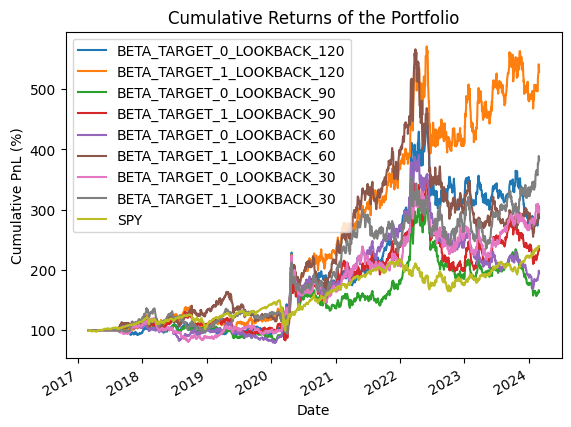

In [16]:
plt.figure(figsize=(14, 6))
(cumulative_pnl).plot()
plt.title('Cumulative Returns of the Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (%)')
plt.legend(loc='best')
plt.show()

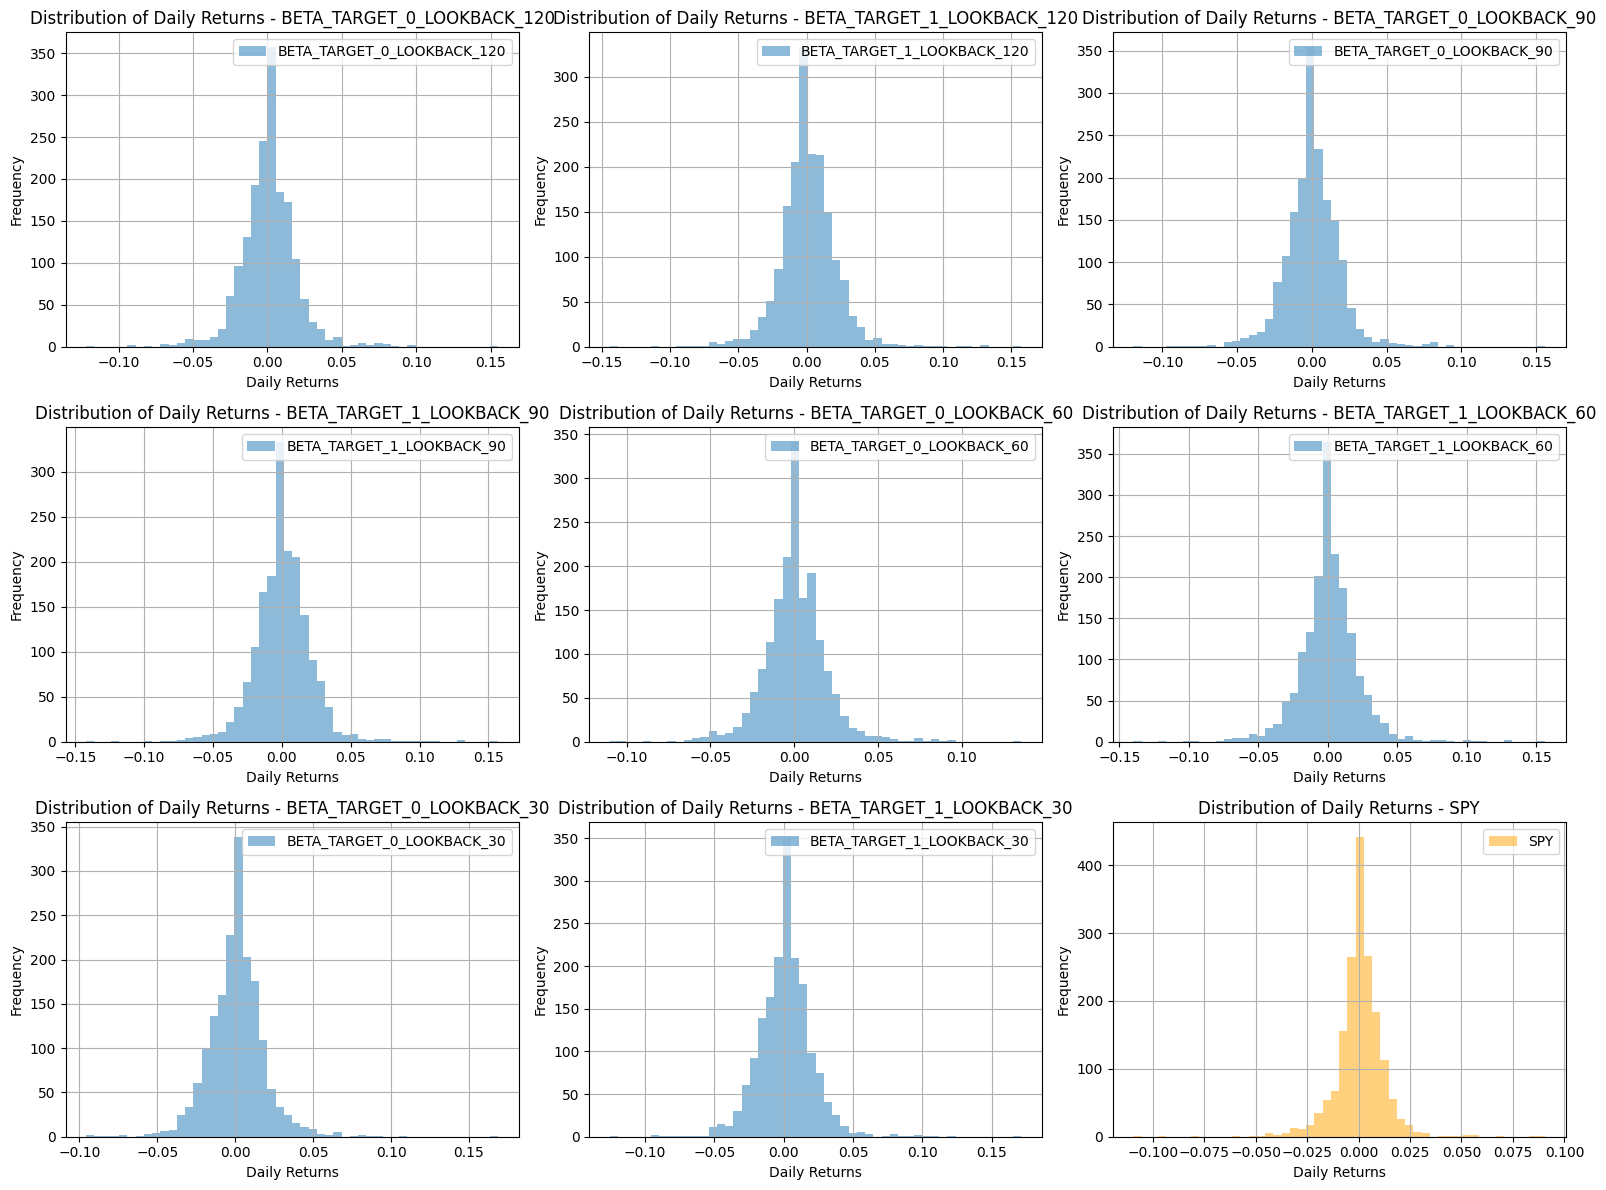

In [17]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(portfolio_ret.columns):
    plt.subplot(3, 3, i + 1)
    if col == 'SPY':
        portfolio_ret[col].hist(bins=50, alpha=0.5, label=col, color='orange')
    else:
        portfolio_ret[col].hist(bins=50, alpha=0.5, label=col)
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Daily Returns - {col}')
    plt.legend()

plt.tight_layout()
plt.show()